In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

## Functions

### Weigfun

In [2]:
def Weigfun( Tlag): 
    # WEIGFUN Summary of this function goes here
    #   Detailed explanation goes here
    nmax=int(np.ceil(Tlag))
    if nmax==1: 
        Weigths=float(1)
    else:
        Weigths=np.zeros(nmax)

        th=Tlag/2
        nh=int(np.floor(th))
        for i in range(0,nh): 
            Weigths[i]=(float(i+1)-0.5)/th	    
        i=nh

        Weigths[i]=(1+(float(i+1)-1)/th)*(th-int(np.floor(th)))/2+(1+(Tlag-float(i+1))/th)*(int(np.floor(th))+1-th)/2
        for i in range(nh+1, int(np.floor(Tlag))):
            Weigths[i]=(Tlag-float(i+1)+.5)/th

        if Tlag>int(np.floor(Tlag)):
            Weigths[int(np.floor(Tlag))]=(Tlag-int(np.floor(Tlag)))**2/(2*th)

        Weigths=Weigths/sum(Weigths)

    return(Weigths)

### Wetland

In [3]:
def wetland(  timestep, Par, forcing, Fluxes, States, Ss, landscape_per ):
	#HBVpareto Calculates values of 3 objective functions for HBV model

	Imax=Par[0]
	Ce=Par[1]
	Sumax=Par[2]
	beta=Par[3]
	Cmax=Par[4]
	Kf=Par[5]

	Qo=forcing[:,0]
	Prec=forcing[:,1]
	Etp=forcing[:,2]


	tmax=len(Prec)
	Si=States[:,0]
	Su=States[:,1]
	Sf=States[:,2]

	Eidt=Fluxes[:,0]
	Eadt=Fluxes[:,1]
	Qfdt=Fluxes[:,2]

	dt=1
	t=timestep


	Pdt=Prec[t]*dt
	Epdt=Etp[t]*dt
	# Interception Reservoir
	if Pdt>0:
		Si[t]=Si[t]+Pdt
		Pedt=max(0,Si[t]-Imax)
		Si[t]=Si[t]-Pedt
		Eidt[t]=0
	else:
	# Evaporation only when there is no rainfall
		Pedt=0
		Eidt[t]=min(Epdt,Si[t])
		Si[t]=Si[t]-Eidt[t]

	if t<tmax-1:
		Si[t+1]=Si[t]


	# Unsaturated Reservoir
	if Pedt>0:
		rho=(Su[t]/Sumax)**beta            
		Su[t]=Su[t]+(1-rho)*Pedt
		Qufdt=rho*Pedt
	else:
		Qufdt=0

	# Transpiration
	Epdt=max(0,Epdt-Eidt[t])
	Eadt[t]=Epdt*(Su[t]/(Sumax*Ce))
	Eadt[t]=min(Eadt[t],Su[t])
	Su[t]=Su[t]-Eadt[t]

	#Capillary rise
	Qrdt=(1-Su[t]/Sumax)*Cmax*dt;
	Qrdt=min(Qrdt, Ss[t]/landscape_per);

	if( (Su[t] + Qrdt) > Sumax):
		Qrdt = Sumax - Su[t]

	Su[t] = Su[t] + Qrdt
	Ss[t]=Ss[t]-Qrdt*landscape_per

	if t<tmax-1:
		Su[t+1]=Su[t]


	# Fast Reservoir
	Sf[t]=Sf[t]+Qufdt
	Qfdt[t]= dt*Kf*Sf[t]
	Sf[t]=Sf[t]-min(Qfdt[t],Sf[t])
	if t<tmax-1:
		Sf[t+1]=Sf[t]    


	#save output
	States[:,0]=Si
	States[:,1]=Su
	States[:,2]=Sf

	Fluxes[:,0]=Eidt
	Fluxes[:,1]=Eadt
	Fluxes[:,2]=Qfdt


	return(Fluxes, States, Ss)

### Plateu

In [4]:
def plateau(  timestep, Par, forcing, Fluxes, States ):
	#HBVpareto Calculates values of 3 objective functions for HBV model

	Imax=Par[0]
	Ce=Par[1]
	Sumax=Par[2]
	beta=Par[3]
	Pmax=Par[4]
	Kf=Par[5]

	Qo=forcing[:,0]
	Prec=forcing[:,1]
	Etp=forcing[:,2]


	tmax=len(Prec)
	Si=States[:,0]
	Su=States[:,1]
	Sf=States[:,2]

	Eidt=Fluxes[:,0]
	Eadt=Fluxes[:,1]
	Qfdt=Fluxes[:,2]
	Qusdt=Fluxes[:,3]

	dt=1
	t=timestep


	Pdt=Prec[t]*dt
	Epdt=Etp[t]*dt
	# Interception Reservoir
	if Pdt>0:
		Si[t]=Si[t]+Pdt
		Pedt=max(0,Si[t]-Imax)
		Si[t]=Si[t]-Pedt
		Eidt[t]=0
	else:
	# Evaporation only when there is no rainfall
		Pedt=0
		Eidt[t]=min(Epdt,Si[t])
		Si[t]=Si[t]-Eidt[t]

	if t<tmax-1:
		Si[t+1]=Si[t]


	# Unsaturated Reservoir
	if Pedt>0:
		rho=(Su[t]/Sumax)**beta            
		Su[t]=Su[t]+(1-rho)*Pedt
		Qufdt=rho*Pedt
	else:
		Qufdt=0

	# Transpiration
	Epdt=max(0,Epdt-Eidt[t])
	Eadt[t]=Epdt*(Su[t]/(Sumax*Ce))
	Eadt[t]=min(Eadt[t],Su[t])
	Su[t]=Su[t]-Eadt[t]

	# Percolation
	Qusdt=(Su[t]/Sumax)*Pmax*dt
	Su[t]=Su[t]-min(Qusdt,Su[t])
	if t<tmax-1:
		Su[t+1]=Su[t]

	# Fast Reservoir
	Sf[t]=Sf[t]+Qufdt
	Qfdt[t]= dt*Kf*Sf[t]
	Sf[t]=Sf[t]-min(Qfdt[t],Sf[t])
	if t<tmax-1:
		Sf[t+1]=Sf[t]
	    
	    

	#save output
	States[:,0]=Si
	States[:,1]=Su
	States[:,2]=Sf

	Fluxes[:,0]=Eidt
	Fluxes[:,1]=Eadt
	Fluxes[:,2]=Qfdt
	Fluxes[:,3]=Qusdt

	return(Fluxes, States)

### Hilslope

In [5]:
def hillslope(  timestep, Par, forcing, Fluxes, States ):
	#HBVpareto Calculates values of 3 objective functions for HBV model

	Imax=Par[0]
	Ce=Par[1]
	Sumax=Par[2]
	beta=Par[3]
	D=Par[4]
	Kf=Par[5]
	Qo=forcing[:,0]
	Prec=forcing[:,1]
	Etp=forcing[:,2]


	tmax=len(Prec)
	Si=States[:,0]
	Su=States[:,1]
	Sf=States[:,2]

	Eidt=Fluxes[:,0]
	Eadt=Fluxes[:,1]
	Qfdt=Fluxes[:,2]
	Qusdt=Fluxes[:,3]

	dt=1
	t=timestep


	Pdt=Prec[t]*dt
	Epdt=Etp[t]*dt
	# Interception Reservoir
	if Pdt>0:
		Si[t]=Si[t]+Pdt
		Pedt=max(0,Si[t]-Imax)
		Si[t]=Si[t]-Pedt
		Eidt[t]=0
	else:
	# Evaporation only when there is no rainfall
		Pedt=0
		Eidt[t]=min(Epdt,Si[t])
		Si[t]=Si[t]-Eidt[t]

	if t<tmax-1:
		Si[t+1]=Si[t]


	# Unsaturated Reservoir
	if Pedt>0:
		rho=(Su[t]/Sumax)**beta            
		Su[t]=Su[t]+(1-rho)*Pedt
		Qufdt=rho*Pedt
	else:
		Qufdt=0

	# Transpiration
	Epdt=max(0,Epdt-Eidt[t])
	Eadt[t]=Epdt*(Su[t]/(Sumax*Ce))
	Eadt[t]=min(Eadt[t],Su[t])
	Su[t]=Su[t]-Eadt[t]
	if t<tmax-1:
		Su[t+1]=Su[t]

	# Preferential Percolation
	Qusdt= D * Qufdt

	# Fast Reservoir
	Sf[t]=Sf[t]+(1-D)*Qufdt
	Qfdt[t]= dt*Kf*Sf[t]
	Sf[t]=Sf[t]-min(Qfdt[t],Sf[t])
	if t<tmax-1:
		Sf[t+1]=Sf[t]    


	#save output
	States[:,0]=Si
	States[:,1]=Su
	States[:,2]=Sf

	Fluxes[:,0]=Eidt
	Fluxes[:,1]=Eadt
	Fluxes[:,2]=Qfdt
	Fluxes[:,3]=Qusdt

	return(Fluxes, States)

### FLEXtopo

In [6]:
def FLEXtopo( ParPlateau, ParHillslope, ParWetland, ParCatchment,forcing, landscapes,in_states,slow_res,spin_up_time='false'):
    #parameters and constants
    Tlag=ParCatchment[1]
    Ks=ParCatchment[0]
    dt=1
    tmax=len(forcing[:,0])

    #initialize states
    States_plateau=np.zeros((tmax,3))
    States_hillslope=np.zeros((tmax,3))
    States_wetland=np.zeros((tmax,3))
    Ss=np.zeros((tmax,1))
    Ss[0]=slow_res
    States_hillslope[0,:]= in_states[0,:]
    States_plateau[0,:]= in_states[1,:]
    States_wetland[0,:]= in_states[2,:]

    #initialize fluxes
    Fluxes_plateau=np.zeros((tmax,4))
    Fluxes_hillslope=np.zeros((tmax,4))
    Fluxes_wetland=np.zeros((tmax,3))
    Qsdt=np.zeros(tmax)
    Qtotdt=np.zeros(tmax)

    #loop over time
    for t in range(0,tmax):

        #plateau
        Fluxes_plateau, States_plateau=plateau( t, ParPlateau, forcing, Fluxes_plateau, States_plateau )
        #hillslope
        Fluxes_hillslope, States_hillslope=hillslope( t, ParHillslope, forcing, Fluxes_hillslope, States_hillslope )

        #wetland
        Fluxes_wetland, States_wetland, Ss=wetland( t, ParWetland, forcing, Fluxes_wetland, States_wetland, Ss, landscapes[2] )

        # Slow Reservoir
        Ss[t]=Ss[t]+ Fluxes_plateau[t,3] * landscapes[0] + Fluxes_hillslope[t,3] * landscapes[1] 
        Qsdt= dt*Ks*Ss[t] 
        Ss[t]=Ss[t]-min(Qsdt,Ss[t])
        if t<tmax-1:
            Ss[t+1]=Ss[t]

        Qtotdt[t]=Qsdt + Fluxes_plateau[t,2] * landscapes[0] + Fluxes_hillslope[t,2] * landscapes[1] +  Fluxes_wetland[t,2] * landscapes[2] 

    # Offset Q
    Weigths=Weigfun(Tlag)

    Qm = np.convolve(Qtotdt,Weigths)
    Qm=Qm[0:tmax]
    Qo=forcing[:,0]
    Qm_wb= Qm # Using full Qm for Water Balance
    Prec=forcing[:,1]
    # Spin up time inclusion
    if spin_up_time=='TRUE':
        tsp=60
    else:
        tsp=0
    Qm= Qm[tsp:tmax]
    Qo= Qo[tsp:tmax]
        # final States
    f_states= np.zeros_like(in_states)
    f_states[0,:]= States_hillslope[-1,:]* landscapes[1]# Multiplying with landscape percetages
    f_states[1,:]= States_plateau[-1,:]* landscapes[0]
    f_states[2,:]= States_wetland[-1,:]* landscapes[2]
    Ss_final=Ss[-1]
    S_final= sum(f_states[:,0]) + sum(f_states[:,1]) + sum(f_states[:,2]) + Ss_final
    in_states[0,:]= in_states[0,:]* landscapes[1]# Multiplying with landscape percetages
    in_states[1,:]=  in_states[1,:]* landscapes[0]
    in_states[2,:]=  in_states[2,:]* landscapes[2]
    S_int= sum(in_states[:,0]) + sum(in_states[:,1])+ sum(in_states[:,2]) + slow_res
    E_wtl=(sum(Fluxes_wetland[:,0]) + sum(Fluxes_wetland[:,1]))* landscapes[2]# Multiplying with landscape percetages
    E_hil=(sum(Fluxes_hillslope[:,0])+ sum(Fluxes_hillslope[:,1]))* landscapes[1]
    E_plt= (sum(Fluxes_plateau[:,0])+ sum(Fluxes_plateau[:,1]))* landscapes[0]
    E_tot= E_wtl + E_hil + E_plt
    WB= sum(Prec[:]) + S_int - S_final - sum(Qm_wb[:]) - E_tot
    # Calculate objective
    ind=np.where((Qo>0))
    #ind= Qo>0
    QoAv=np.mean(Qo[ind])
    ErrUp=(Qm[ind] - Qo[ind])**2
    ErrDo=(Qo[ind] - QoAv)**2
    Obj= 1 - (sum(ErrUp)/ sum(ErrDo))
    #Calculating Log Nash coefficient
    ind= np.where((Qo>0) & (Qm>0))
    LErrUp=(np.log10(Qo[ind]) - np.log10(Qm[ind]))**2
    LErrDo=(np.log10(Qo[ind]) - np.mean(np.log10(Qo[ind])))**2
    LObj= 1 - (sum(LErrUp)/ sum(LErrDo))
    return(Obj,LObj,Qm,f_states,Ss_final,WB)

## Run Model

### Calibration - Validation

2nd OptPar NSE  0.569 and log NSE  0.758 for full data set  when modell is run in one phase (spin up time)


<Figure size 1440x360 with 0 Axes>

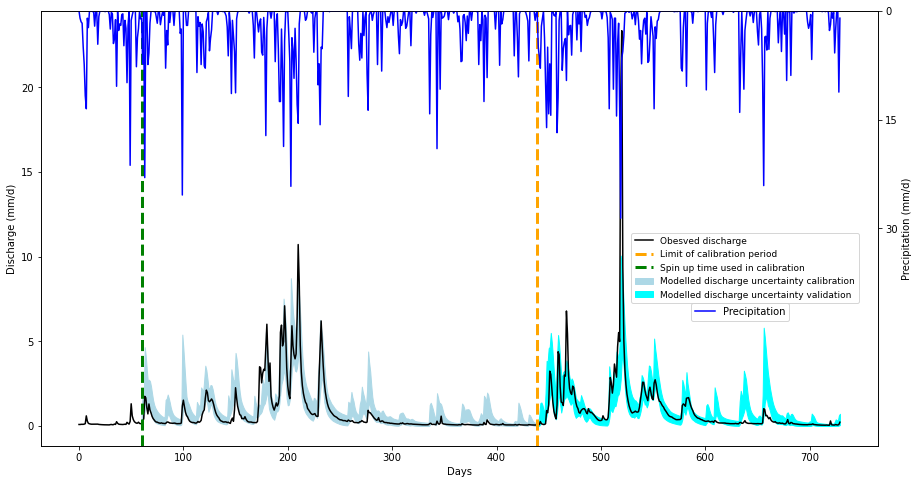

In [7]:
forcing=np.genfromtxt('WarkEttelbruck.txt',  dtype=float, autostrip=True)
forcing= forcing[:,1:4]
Q0= forcing[:,0]
tsp=60# Spin up time
#Plateau                   #  Imax Ce Sumax beta Pmax    Kf  
ParMinn_pl   = np.array([0,  0.01,   20, 0.02, 0.1, 0.05])
ParMaxn_pl   = np.array([15, 0.95, 450, 0.99, 3.5, 0.95])


#Hillslope   #      Imax Ce Sumax beta D  Kf
ParMinn_hill   = np.array([0,  0.01,   50, 0.02, 0.5, 0.05])
ParMaxn_hill  = np.array([15, 0.95, 500, 0.99, 2.5, 0.95])

#Wetland      #            Imax Ce Sumax beta Cmax  Kf  
ParMinn_wtl   = np.array([0,  0.01,   25, 0.02, 0.1, 0.1])
ParMaxn_wtl  = np.array([15, 0.95, 350, 0.99, 3.5, 1.2])

#                       Ks    ,  Tlag
ParCatchMinn = np.array([0.001, 0.5])
ParCatchMaxn = np.array([0.25, 5])


forcing_cal= forcing[:440,:] # Around 60 % of the data is chosen for calibration
forcing_val= forcing[440:,:]
#landscape percentages
land_distr=np.array([0.44316-0.00630514346380575, 0.44550-0.006338390188025569, 0.12577-0.0017894560388902797])
#
nmax = 5000;
Wtl=np.zeros((nmax,6))  #Wetland
Hls=np.zeros((nmax,6))   #Hillslope
Plat=np.zeros((nmax,6))    #Plateau
Ctch = np.zeros((nmax, 2))  #Catchment
eff_Table=np.zeros((nmax,8))  #Efficiency Table
Q_cal=np.zeros((nmax,len(forcing_cal[60:,0])))
Q_val=np.zeros((nmax,len(forcing_val[:,0])))
n_feasible = 0
#Initial States
in_states=np.zeros((3,3))
#in_states[:,2]= [40,5,10] 
slow_res=5
WB=np.zeros((nmax,2))
for i in range (0,nmax):
    Rnum=np.random.rand(6)
    Parhls=(ParMaxn_hill- ParMinn_hill) * Rnum + ParMinn_hill
    Rnum=np.random.rand(6)
    Parwtl=(ParMaxn_wtl- ParMinn_wtl) * Rnum + ParMinn_wtl
    Rnum=np.random.rand(6)
    Parplat=(ParMaxn_pl- ParMinn_pl) * Rnum + ParMinn_pl
    Rnum= np.random.rand(2)
    ParCatch=(ParCatchMaxn - ParCatchMinn) * Rnum + ParCatchMinn
    #Calibration-Validation runs
    NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(Parplat,Parhls,Parwtl,ParCatch,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
    NS_val,log_NS_val,Qm_val,S_final_val,Ss_final,WB_val=FLEXtopo(Parplat,Parhls,Parwtl,ParCatch,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
    #Chosing based on NS and log NS 
    if (NS_cal> 0.2) & (log_NS_cal>0.2) & (abs(WB_cal)<=1):
        Wtl[n_feasible,:]= Parwtl
        Hls[n_feasible,:]= Parhls
        Plat[n_feasible,:]= Parplat
        Ctch[n_feasible,:]= ParCatch
        eff_Table[n_feasible,0]= NS_cal
        eff_Table[n_feasible,1]= log_NS_cal
        eff_Table[n_feasible,2]= NS_val
        eff_Table[n_feasible,3]= log_NS_val
        Q_cal[n_feasible,:]= Qm_cal
        Q_val[n_feasible,:]= Qm_val
        WB[n_feasible,:]= WB_cal,WB_val
        n_feasible += 1
eff_Table= eff_Table[0:n_feasible,:]
Wtl=Wtl[0:n_feasible,:]
Hls=Hls[0:n_feasible,:]
Plat=Plat[0:n_feasible,:]
Ctch=Ctch[0:n_feasible,:]
Q_cal=Q_cal[0:n_feasible,:]
Q_val=Q_val[0:n_feasible,:]
WB=WB[n_feasible,:]
eff_Table[:,4]= eff_Table[:,0]/sum(eff_Table[:,0])# NSE cal weigthed
eff_Table[:,5]= eff_Table[:,1]/sum(eff_Table[:,1])# LOG nse CAL
eff_Table[:,6]= eff_Table[:,2]/sum(eff_Table[:,2])# NSE val weigthed
eff_Table[:,7]= eff_Table[:,3]/sum(eff_Table[:,3])# LOG nse val
np.savetxt('Efficiencys_Table.txt', eff_Table, delimiter=",")
np.savetxt('PlataeuPar_Table.txt', Plat[0:n_feasible,:], delimiter=",")
np.savetxt('HillslopePar_Table.txt', Hls[0:n_feasible,:], delimiter=",")
np.savetxt('WetlandPar_Table.txt', Wtl[0:n_feasible,:], delimiter=",")
np.savetxt('CatchPar_Table.txt', Ctch[0:n_feasible,:], delimiter=",")
#                      #
#                      #
#                      #  
#                      #
# Calibration table    #
#                      #
#                      #
#                      #
#                      #
Qdt= np.zeros(n_feasible)
Qdt_top_cal= np.zeros(len(Q_cal[1]))
Qdt_bot_cal= np.zeros(len(Q_cal[1]))

for i in range(len(Q_cal[1])):
    Qdt= Q_cal[:,i]
    Table_cal= np.column_stack((eff_Table[:n_feasible,:],Qdt.T))
    Table_caldf=pd.DataFrame(data=Table_cal, index=np.arange(n_feasible))
    Table_caldf.sort_values(by=[8],inplace=True)
    Table_caldf.columns=['NSE_cal','logN_cal','NSE_val','logN_val','Weighted_NSE','Weighted_log_NSE','Weighted_val_NSE','Weighted_val_log_NSE','Qdt']
    Table_caldf['Cumsum_WNSE']=Table_caldf['Weighted_NSE'].cumsum()
    # Finding upper-lowwer uncertainty boundaries
    Q_top_matrix= Table_caldf['Qdt'][Table_caldf['Cumsum_WNSE'] >= np.percentile(Table_caldf['Cumsum_WNSE'],95)]
    Q_bot_matrix= Table_caldf['Qdt'][Table_caldf['Cumsum_WNSE'] <= np.percentile(Table_caldf['Cumsum_WNSE'],5)]
    Qdt_top_cal[i]= np.min(Q_top_matrix)
    Qdt_bot_cal[i]= np.max(Q_bot_matrix)
#Exporting table
Table_caldf.reset_index(inplace=True)
Table_caldf.to_excel('2nd_Model_Table_cal.xlsx')  
#                   #
#                   #
#                   #
#                   #
# Validation Table  #
#                   #
#                   #
#                   #
#                   #
Qdt= np.zeros(n_feasible)
Qdt_top_val= np.zeros(len(Q_val[0,:]))
Qdt_bot_val= np.zeros(len(Q_val[0,:]))

for j in range(len(Q_val[0,:])):
    Qdt= Q_val[:,j]
    Table_val= np.column_stack((eff_Table[:n_feasible,:],Qdt.T))
    Table_valdf=pd.DataFrame(data=Table_val, index=np.arange(n_feasible))
    Table_valdf.sort_values(by=[8],ascending=True,inplace=True)
    Table_valdf.columns=['NSE_cal','logN_cal','NSE_val','logN_val','Weighted_NSE','Weighted_log_NSE','Weighted_val_NSE','Weighted_val_log_NSE','Qdt_val']
    Table_valdf['Cumsum_val_WNSE']=Table_valdf['Weighted_val_NSE'].cumsum()
    # Finding upper-lowwer uncertainty boundaries
    Q_top_matrix= Table_valdf['Qdt_val'][Table_valdf['Cumsum_val_WNSE'] >= np.percentile(Table_valdf['Cumsum_val_WNSE'],95)]
    Q_bot_matrix= Table_valdf['Qdt_val'][Table_valdf['Cumsum_val_WNSE'] <= np.percentile(Table_valdf['Cumsum_val_WNSE'],5)]
    Qdt_top_val[j]= np.min(Q_top_matrix)
    Qdt_bot_val[j]= np.max(Q_bot_matrix)
#Exporting table
Table_valdf.reset_index(inplace=True)
Table_valdf.to_excel('2nd_Model_Table_val.xlsx')

#find the optimum

Opt= np.argmax(eff_Table[:,0] + eff_Table[:,1])
#find the optimal parameter set
OptPar_plat= Plat[Opt,:]
OptPar_hill= Hls[Opt,:]
OptPar_wtl= Wtl[Opt,:]
OptParctch= Ctch[Opt,:]
OptPar=np.zeros((4,6))
OptPar[0,:]=OptPar_plat
OptPar[1,:]=OptPar_hill
OptPar[2,:]=OptPar_wtl
OptPar[3,:2]=OptParctch
np.savetxt('Opt_Par_set.txt',OptPar[:,:], delimiter =',')
OptPar=pd.DataFrame(data=OptPar,index=['Plattaeu','Hillslope','Wetland','Catchment'])
OptPar.to_excel('Optimum_Pararmeter_Set.xlsx')

#
NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(OptPar_plat,OptPar_hill,OptPar_wtl,OptParctch,forcing=forcing,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
#                                                       #
#                                                       #
# Plotting Uncertainty in Qm with Precipitation and Qobs#
#                                                       #
#                                                       #
# Final Figure
t_cal= np.arange(tsp,len(Qdt_top_cal)+tsp)
t0_val=len(Qdt_top_cal)+tsp
tmax=len(Q0)
t_val= np.arange(t0_val,tmax)
tobs= np.arange(0,len(Q0))
#
fig = plt.figure(figsize=(20, 5))
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)
ax1.plot(Q0, color='k', label='Obesved discharge')
ax2 = ax1.twinx()
ax2 = plt.gca()
ax2.set_ylim(-60,0)
ax2.set_yticks([0,-15,-30])
ax2.set_yticklabels(['0','15','30'])
ax2.set_ylabel('Precipitation (mm/d)')
ax1.set_ylabel('Discharge (mm/d)')
ax1.set_xlabel('Days')
ax2.plot(tobs,-forcing[:,1], 'b-',label='Precipitation')
ax1.axvline(np.max(t_cal), linewidth=3, linestyle='--', color='orange', label='Limit of calibration period')
ax1.axvline(tsp, linewidth=3, linestyle='--', color='green', label='Spin up time used in calibration')
ax1.fill_between(t_cal,Qdt_bot_cal,Qdt_top_cal,color='lightblue', label='Modelled discharge uncertainty calibration')
ax1.fill_between(t_val, Qdt_bot_val, Qdt_top_val, color='cyan', label='Modelled discharge uncertainty validation')
ax1.legend(bbox_to_anchor=(0.7, 0.5), prop={'size': 9})
ax2.legend(bbox_to_anchor=(0.9, 0.34), prop={'size': 10})
plt.savefig('Model_2_Qobs_Prec_Qm+Uncertainty')
print(f'2nd OptPar NSE {NS: .3f} and log NSE {log_NS: .3f} for full data set  when modell is run in one phase (spin up time)')
#
#g=FLEXtopo(OptPar.loc['Plattaeu',:],OptPar.loc['Hillslope',:],OptPar.loc['Wetland',:],OptPar.iloc[3,:2],forcing=forcing,landscapes=land_distr,in_states=S_final_cal,slow_res=slow_res,spin_up_time='TRUE')#
#Qopt = g[2]#
#Qm=np.zeros_like(Q0)#
#Qm[60:]=Qopt#
#f=plt.figure(figsize=(12,8)#
#plt.plot(Q0[:],label='Observed')#
#plt.plot(Qm[:],label='Best fit NSE')#
#plt.xlabel('Days')#
#plt.ylabel('Discharge(mm)')#
#plt.legend()#
#plt.title('2nd model Optimum parameter discharge versus Observed, 60 days spin up time')#
#plt.savefig('OptPar_Fit_Q0-Qm')#

### Plot optimum values

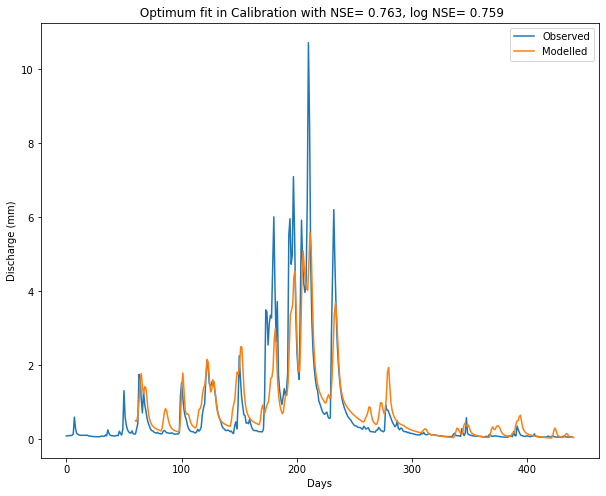

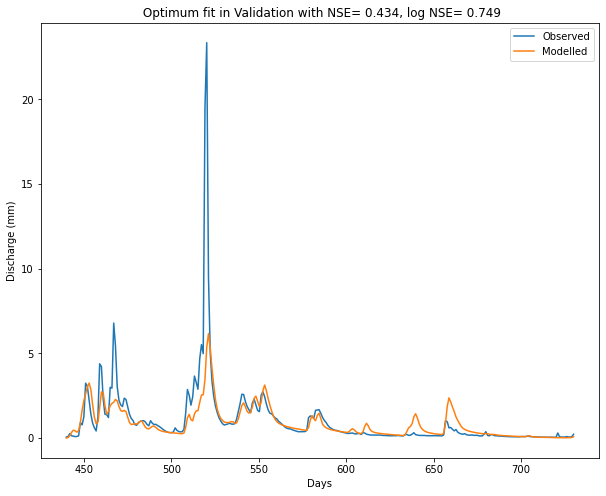

In [8]:
OptPar= np.genfromtxt('Opt_Par_set.txt', delimiter =',', dtype=float, autostrip=True)
forcing=np.genfromtxt('WarkEttelbruck.txt',  dtype=float, autostrip=True)
forcing= forcing[:,1:4]
Q0= forcing[:,0]
Parplat = OptPar[0,:]
Parhls = OptPar[1,:]
Parwtl = OptPar[2,:]
ParCatch = OptPar[3,:2]
slow_res=5
in_states=np.zeros((3,3))
land_distr=np.array([0.44316-0.00630514346380575, 0.44550-0.006338390188025569, 0.12577-0.0017894560388902797])
NSE_cal,log_NSE_cal,Qm_cal,S_final_cal,Ss_final_cal,WB_cal=FLEXtopo(Parplat,Parhls,Parwtl,ParCatch,forcing=forcing[:440,:],landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
tm= np.linspace(60,440,380)
plt.figure(figsize=(10,8))
plt.plot(Q0[:440],label='Observed')
plt.plot(tm,Qm_cal,label='Modelled')
plt.ylabel('Discharge (mm)')
plt.xlabel('Days')
plt.legend()
plt.title(f' Optimum fit in Calibration with NSE= {NSE_cal:.3f}, log NSE= {log_NSE_cal:.3f}')
plt.savefig('Optimum_Fit_cal_M_2')
# Validation fit
forcing_val= forcing[440:,:]
forcing_cal = forcing[:440,:]
#
NSE_cal,log_NSE_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(OptPar[0,:],OptPar[1,:],OptPar[2,:],OptPar[3,:2],forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
NSE_val,log_NSE_val,Qm_val,S_final,Ss_final,WB=FLEXtopo(OptPar[0,:],OptPar[1,:],OptPar[2,:],OptPar[3,:2],forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
tm= np.linspace(440,730,290)
plt.figure(figsize=(10,8))
plt.plot(tm,Q0[440:],label='Observed')
plt.plot(tm,Qm_val,label='Modelled')
plt.ylabel('Discharge (mm)')
plt.xlabel('Days')
plt.legend()
plt.title(f' Optimum fit in Validation with NSE= {NSE_val:.3f}, log NSE= {log_NSE_val:.3f}')
plt.savefig('Optimum_Fit_Val_M_2')

### Monte Carlo - NSE & logNSE

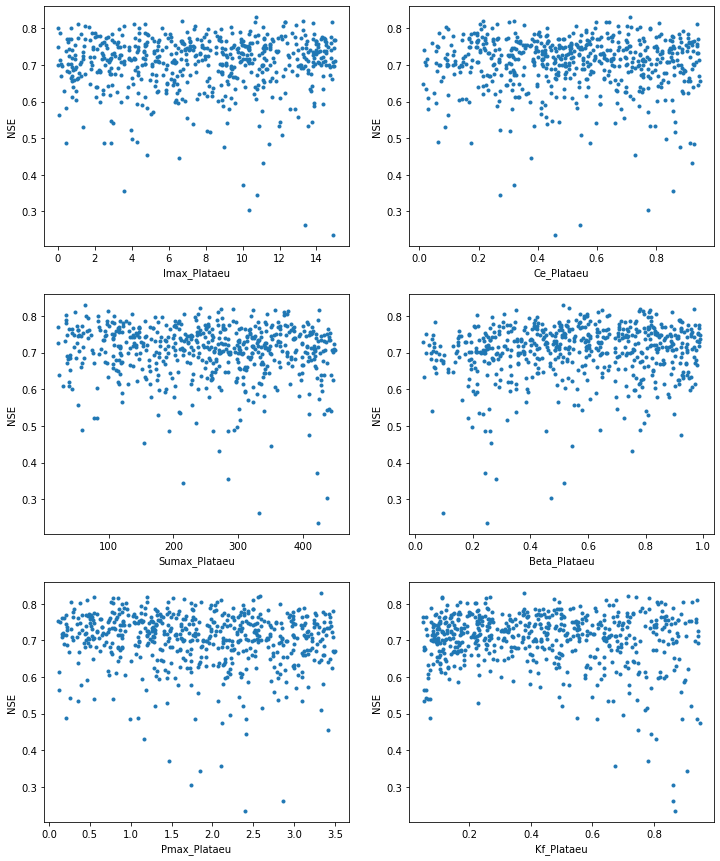

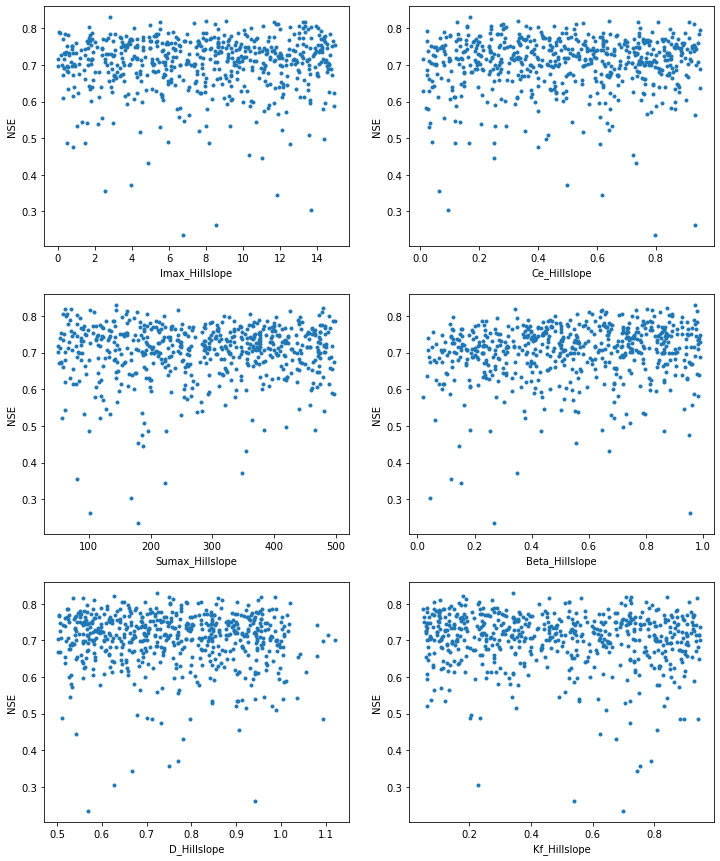

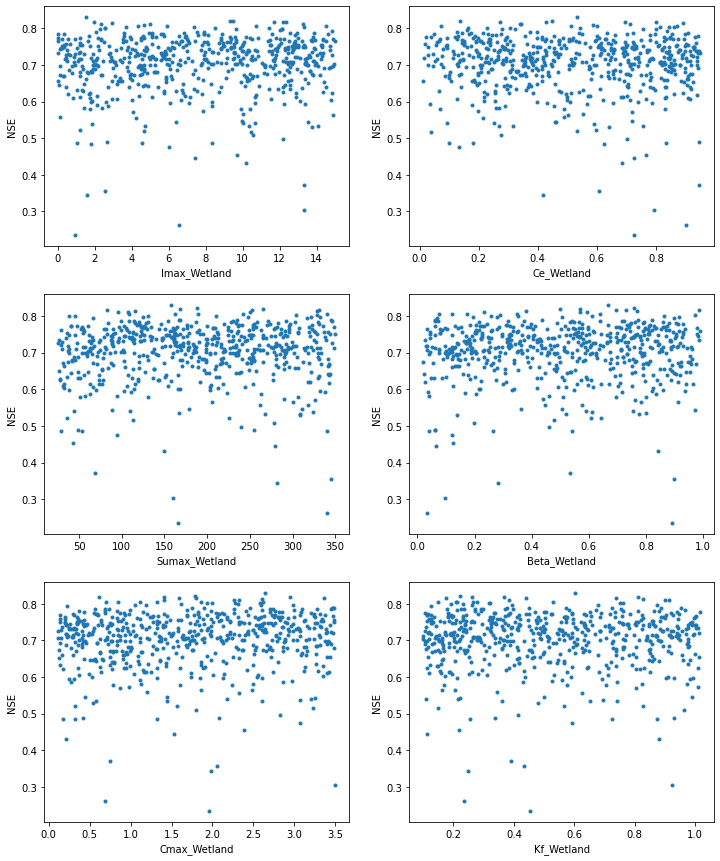

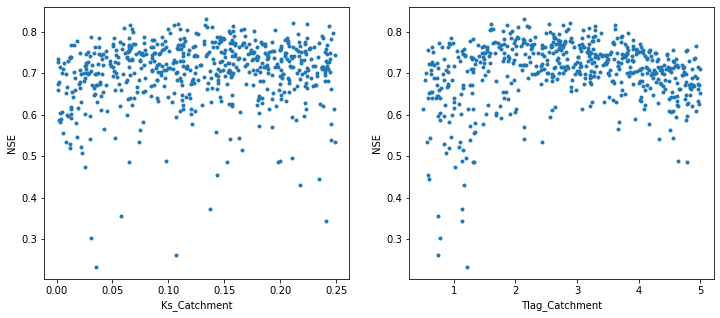

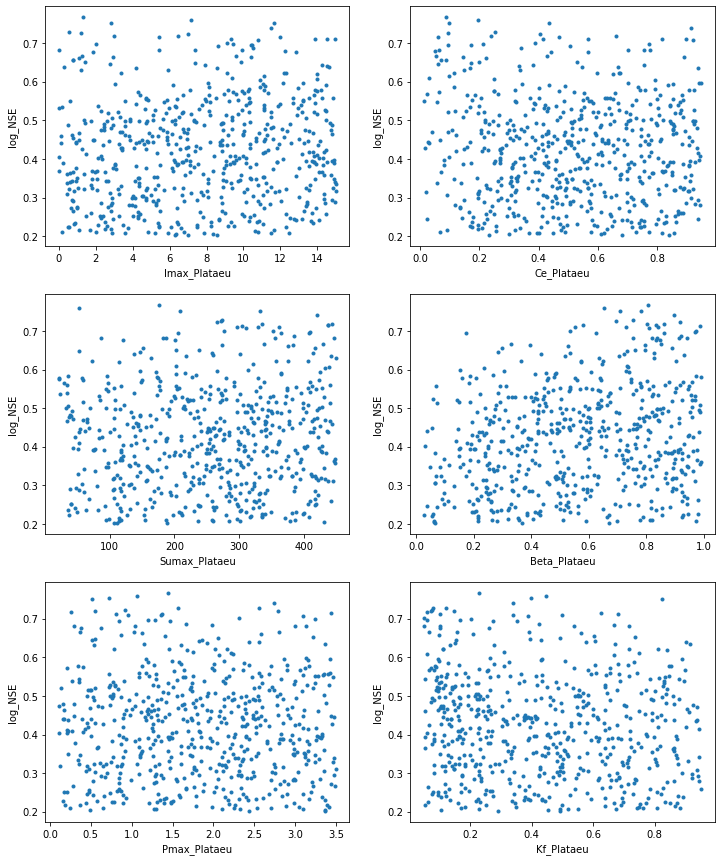

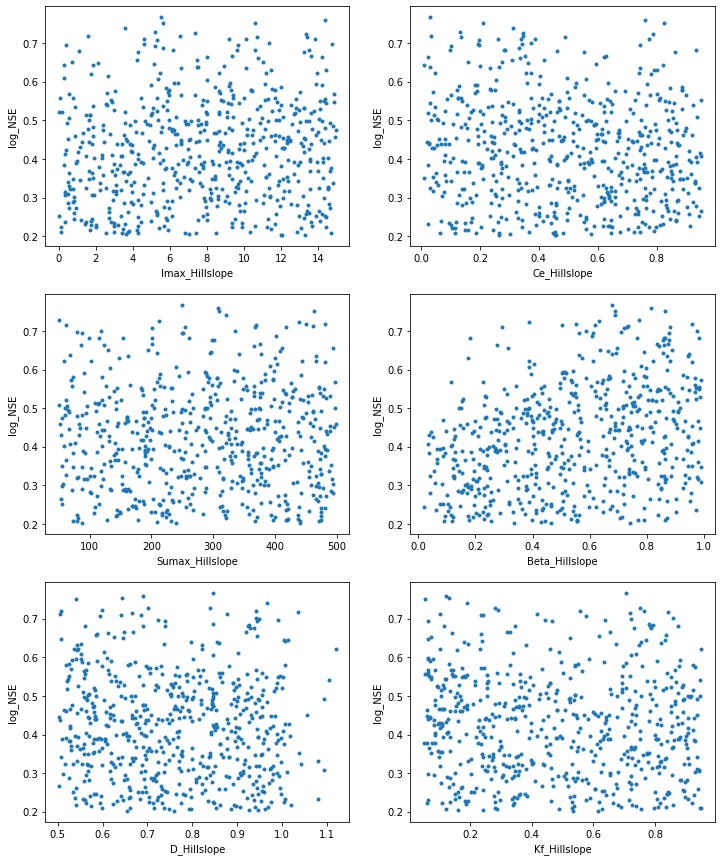

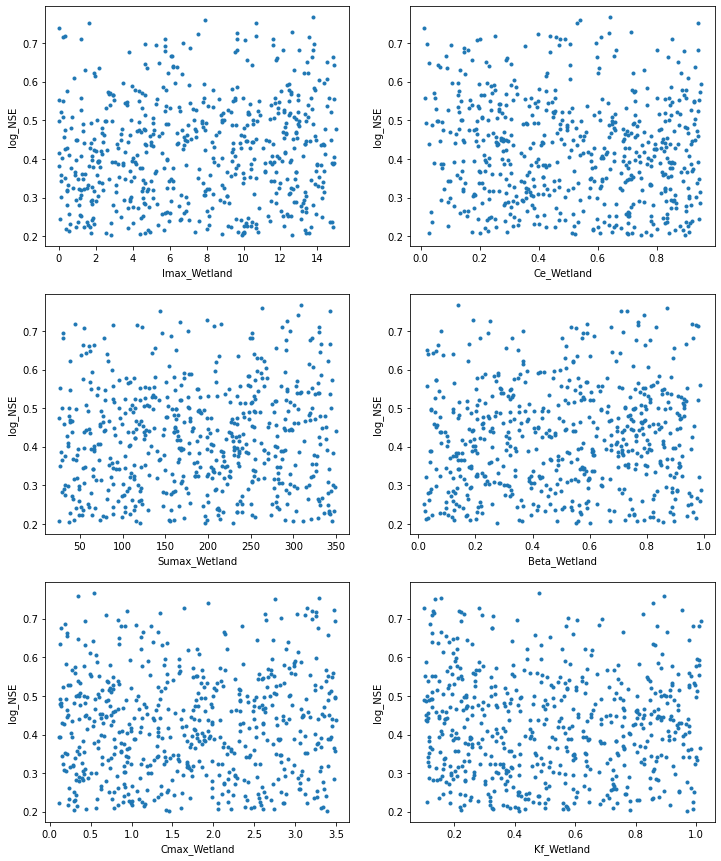

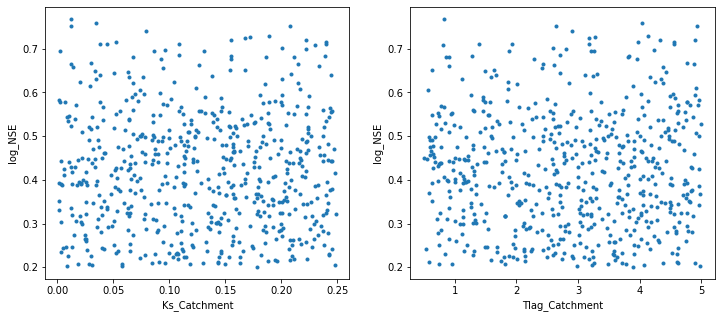

In [9]:
#
eff_table=np.genfromtxt('Efficiencys_Table.txt',  dtype=float, autostrip=True, delimiter=',')
#
PlateuPar_Table=np.genfromtxt('PlataeuPar_Table.txt',  dtype=float, autostrip=True, delimiter=',')
HillslopePar_Table=np.genfromtxt('HillslopePar_Table.txt',  dtype=float, autostrip=True, delimiter=',')
WetlandPar_Table=np.genfromtxt('WetlandPar_Table.txt',  dtype=float, autostrip=True, delimiter=',')
CatchPar_Table=np.genfromtxt('CatchPar_Table.txt',  dtype=float, autostrip=True, delimiter=',')
#
PL_clms=['Imax_Plataeu', 'Ce_Plataeu', 'Sumax_Plataeu', 'Beta_Plataeu', 'Pmax_Plataeu', 'Kf_Plataeu']
Hls_clms=['Imax_Hillslope', 'Ce_Hillslope', 'Sumax_Hillslope', 'Beta_Hillslope', 'D_Hillslope', 'Kf_Hillslope']
Wtl_clms=['Imax_Wetland', 'Ce_Wetland', 'Sumax_Wetland', 'Beta_Wetland', 'Cmax_Wetland', 'Kf_Wetland']
Ctch_clms=['Ks_Catchment','Tlag_Catchment']
#
plt.figure(figsize=(12,15))
for i in range(6):
    sbpl=321+i
    plt.subplot(sbpl)
    plt.plot(PlateuPar_Table[:,i],eff_table[:,0],'.')
    plt.xlabel(PL_clms[i])
    plt.ylabel('NSE')
plt.savefig('Monte_Carlo_NSE_plots_PLAT.png') 
plt.figure(figsize=(12,15))  
for i in range(6):
    sbpl=321+i
    plt.subplot(sbpl)
    plt.plot(HillslopePar_Table[:,i],eff_table[:,0],'.')
    plt.xlabel(Hls_clms[i])
    plt.ylabel('NSE')
plt.savefig('Monte_Carlo_NSE_plots_HIL.png')
plt.figure(figsize=(12,15))
for i in range(6):
    sbpl=321+i
    plt.subplot(sbpl)
    plt.plot(WetlandPar_Table[:,i],eff_table[:,0],'.')
    plt.xlabel(Wtl_clms[i])
    plt.ylabel('NSE')
plt.savefig('Monte_Carlo_NSE_plots_WET.png')
plt.figure(figsize=(12,5))
for i in range(2):
    sbpl=121+i
    plt.subplot(sbpl)
    plt.plot(CatchPar_Table[:,i],eff_table[:,0],'.')
    plt.xlabel(Ctch_clms[i])
    plt.ylabel('NSE')
plt.savefig('Monte_Carlo_NSE_plots_CTCH.png')
#LOG NSE
plt.figure(figsize=(12,15))
for i in range(6):
    sbpl=321+i
    plt.subplot(sbpl)
    plt.plot(PlateuPar_Table[:,i],eff_table[:,1],'.')
    plt.xlabel(PL_clms[i])
    plt.ylabel('log_NSE')
plt.savefig('Monte_Carlo_logNSE_plots_PLAT.png') 
plt.figure(figsize=(12,15))  
for i in range(6):
    sbpl=321+i
    plt.subplot(sbpl)
    plt.plot(HillslopePar_Table[:,i],eff_table[:,1],'.')
    plt.xlabel(Hls_clms[i])
    plt.ylabel('log_NSE')
plt.savefig('Monte_Carlo_logNSE_plots_HIL.png')
plt.figure(figsize=(12,15))
for i in range(6):
    sbpl=321+i
    plt.subplot(sbpl)
    plt.plot(WetlandPar_Table[:,i],eff_table[:,1],'.')
    plt.xlabel(Wtl_clms[i])
    plt.ylabel('log_NSE')
plt.savefig('Monte_Carlo_logNSE_plots_WET.png')
plt.figure(figsize=(12,5))
for i in range(2):
    sbpl=121+i
    plt.subplot(sbpl)
    plt.plot(CatchPar_Table[:,i],eff_table[:,1],'.')
    plt.xlabel(Ctch_clms[i])
    plt.ylabel('log_NSE')
plt.savefig('Monte_Carlo_logNSE_plots_CTCH.png')

### Sensitivity Monte Carlo

In [ ]:
OptPar= np.genfromtxt('Opt_Par_set.txt', delimiter =',', dtype=float, autostrip=True)
forcing=np.genfromtxt('WarkEttelbruck.txt',  dtype=float, autostrip=True)
forcing= forcing[:,1:4]# Calibration forcing Sensitivity analysis
Q0= forcing[0]
forcing_cal=forcing[:440,:]
forcing_val=forcing[440:,:]
tsp=60# Spin up time
#Plateau                   #  Imax Ce Sumax beta Pmax    Kf  
ParMinn_pl   = np.array([0,  0.01,   20, 0.02, 0.1, 0.05])
ParMaxn_pl   = np.array([15, 0.95, 450, 0.99, 3.5, 0.95])


#Hillslope   #      Imax Ce Sumax beta D  Kf
ParMinn_hill   = np.array([0,  0.01,   50, 0.02, 0.5, 0.05])
ParMaxn_hill  = np.array([15, 0.95, 500, 0.99, 2.5, 0.95])

#Wetland      #            Imax Ce Sumax beta Cmax  Kf  
ParMinn_wtl   = np.array([0,  0.01,   25, 0.02, 0.1, 0.1])
ParMaxn_wtl  = np.array([15, 0.95, 350, 0.99, 3.5, 1.2])

#                       Ks    ,  Tlag
ParCatchMinn = np.array([0.001, 0.5])
ParCatchMaxn = np.array([0.25, 5])
#landscape percentages
land_distr=np.array([0.44316-0.00630514346380575, 0.44550-0.006338390188025569, 0.12577-0.0017894560388902797])
#Initial States
in_states=np.zeros((3,3))
#in_states[:,2]= [40,5,10] 
slow_res=5
nmax=5000
par = np.zeros((nmax, 20))
NSE = np.zeros((nmax, 20))
log_NSE = np.zeros((nmax, 20))
ParPlateau =OptPar[0,:]
ParHillslope = OptPar[1,:]
ParWetland = OptPar[2,:]
ParCatchment = OptPar[3,:2]
NSE_cal,log_NSE_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
NSE_val,log_NSE_val,Qm,S_final,Ss_final,WB=FLEXtopo(OptPar[0,:],OptPar[1,:],OptPar[2,:],OptPar[3,:2],forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
for i in range(4):
    number = 0
    if i==0:
        for j in range(6):
            for n in range(nmax):
                Rnum=np.random.rand(1)
                ParPlateau[j]= ParMinn_pl[j] + (ParMaxn_pl[j] - ParMinn_pl[j]) * Rnum
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParPlateau[j]=OptPar[0,j]
                number += 1
                if number%1000 == 0:
                    print(number)
    number = 0
    if i==1:
        for j in range(6,12):
            for n in range(nmax):
                Rnum=np.random.rand(1)
                ParHillslope[j-6]= ParMinn_hill[j-6] + (ParMaxn_hill[j-6] - ParMinn_hill[j-6]) * Rnum
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParHillslope[j-6]=OptPar[1,j-6]
                number += 1
                if number%1000 == 0:
                    print(number)
    number = 0
    if i==2:
        for j in range(12,18):
            for n in range(nmax):
                Rnum=np.random.rand(1)
                ParWetland[j-12]= ParMinn_wtl[j-12] + (ParMaxn_wtl[j-12] - ParMinn_wtl[j-12]) * Rnum
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParWetland[j-12]=OptPar[2,j-12]
                number += 1
                if number%1000 == 0:
                    print(number)
    number = 0
    if i==3:
        for j in range(18,20):
            for n in range(nmax):
                Rnum=np.random.rand(1)
                ParCatchment[j-18]= ParCatchMinn[j-18] + (ParCatchMaxn[j-18] - ParCatchMinn[j-18]) * Rnum
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParCatchment[j-18]=OptPar[3,j-18]
                number += 1
                if number%1000 == 0:
                    print(number)

Plataeu , log_Plataeu = pd.DataFrame(data=NSE[:,0:6],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Kf']) , pd.DataFrame(data=log_NSE[:,0:6],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Kf'])
Hillslpoe , log_Hillslpoe = pd.DataFrame(data=NSE[:,6:12],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'D', 'Kf']) , pd.DataFrame(data=log_NSE[:,6:12],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'D', 'Kf'])
Wetland , log_Wetland = pd.DataFrame(data=NSE[:,12:18],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Cmax', 'Kf']) , pd.DataFrame(data=log_NSE[:,12:18],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Cmax', 'Kf'])
Catchment , log_Catchment = pd.DataFrame(data=NSE[:,18:20],columns=['Ks', 'Tlag']) , pd.DataFrame(data=log_NSE[:,18:20],columns=['Ks', 'Tlag'])
# #
# fig=plt.figure(figsize=(13,25))
# plt.suptitle('Validation NS = '+str(np.round(NSE_val,3))+',log NS = '+str(np.round(log_NSE_val,3)),y=0.9,fontsize=15)
# plt.subplot(421)
# plt.ylabel('NSE')
# plt.ylim(-1,0.95)
# plt.axhline(y=float(NSE_val),label='Opttimum NSE',linestyle='--')
# plt.title('Plateau Parameters')
# Plataeu.plot.box(ax = plt.gca(), sym = '')
# plt.subplot(422)
# plt.ylabel('log_NSE')
# plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
# plt.ylim(-1,0.95)
# plt.title('Plateau Parameters')
# log_Plataeu.plot.box(ax = plt.gca(), sym = '')
# plt.subplot(423)
# plt.ylabel('NSE')
# plt.axhline(y=NSE_val,label='Opttimum NSE',linestyle='--')
# plt.ylim(-1,0.95)
# plt.title('Hillslope Parameters')
# Hillslpoe.plot.box(ax = plt.gca(), sym = '')
# plt.subplot(424)
# plt.ylabel('log_NSE')
# plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
# plt.ylim(-1,0.95)
# plt.title('Hillslope Parameters')
# log_Hillslpoe.plot.box(ax = plt.gca(), sym = '')
# plt.subplot(425)
# plt.ylabel('NSE')
# plt.axhline(y=NSE_val,label='Opttimum NSE',linestyle='--')
# plt.ylim(-1,0.95)
# plt.title('Wetland Parameters')
# Wetland.plot.box(ax = plt.gca(), sym = '')
# plt.subplot(426)
# plt.ylabel('log_NSE')
# plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
# plt.ylim(-1,0.95)
# plt.title('Wetland Parameters')
# log_Wetland.plot.box(ax = plt.gca(), sym = '')
# plt.subplot(427)
# plt.ylabel('NSE')
# plt.axhline(y=NSE_val,label='Opttimum NSE',linestyle='--')
# plt.ylim(-1,0.95)
# plt.title('Catchment Parameters')
# Catchment.plot.box(ax = plt.gca(), sym = '')
# plt.subplot(428)
# plt.ylabel('log_NSE')
# plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
# plt.ylim(-1,0.95)
# plt.title('Catchment Parameters')
# log_Catchment.plot.box(ax = plt.gca(), sym = '')
# plt.savefig('Sensitivity_figure_NSE_log_NSE.png')

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


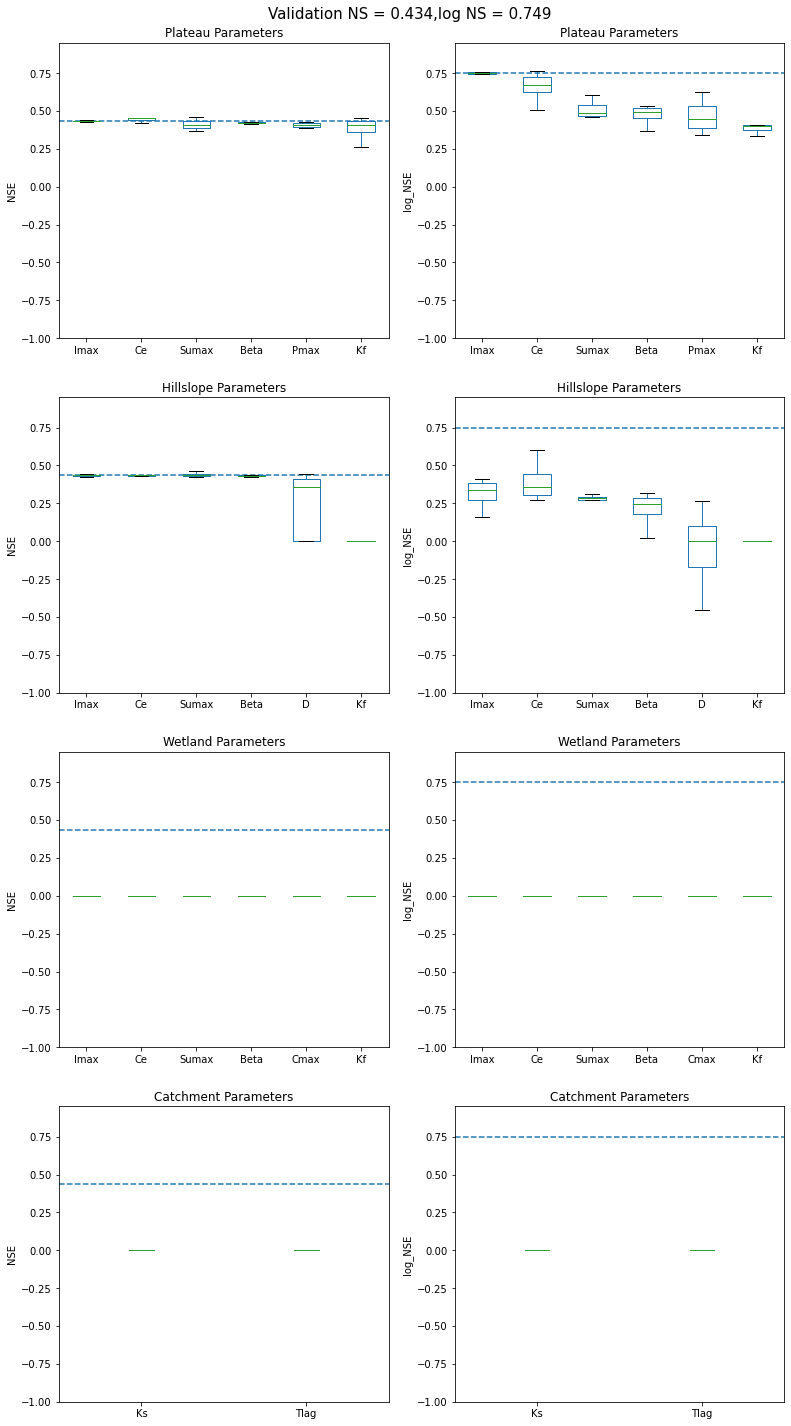

In [12]:
Plataeu , log_Plataeu = pd.DataFrame(data=NSE[:,0:6],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Kf']) , pd.DataFrame(data=log_NSE[:,0:6],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Kf'])
Hillslpoe , log_Hillslpoe = pd.DataFrame(data=NSE[:,6:12],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'D', 'Kf']) , pd.DataFrame(data=log_NSE[:,6:12],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'D', 'Kf'])
Wetland , log_Wetland = pd.DataFrame(data=NSE[:,12:18],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Cmax', 'Kf']) , pd.DataFrame(data=log_NSE[:,12:18],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Cmax', 'Kf'])
Catchment , log_Catchment = pd.DataFrame(data=NSE[:,18:20],columns=['Ks', 'Tlag']) , pd.DataFrame(data=log_NSE[:,18:20],columns=['Ks', 'Tlag'])
#
fig=plt.figure(figsize=(13,25))
plt.suptitle('Validation NS = '+str(np.round(NSE_val,3))+',log NS = '+str(np.round(log_NSE_val,3)),y=0.9,fontsize=15)
plt.subplot(421)
plt.ylabel('NSE')
plt.ylim(-1,0.95)
plt.axhline(y=float(NSE_val),label='Opttimum NSE',linestyle='--')
plt.title('Plateau Parameters')
Plataeu.plot.box(ax = plt.gca(), sym = '')
plt.subplot(422)
plt.ylabel('log_NSE')
plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
plt.ylim(-1,0.95)
plt.title('Plateau Parameters')
log_Plataeu.plot.box(ax = plt.gca(), sym = '')
plt.subplot(423)
plt.ylabel('NSE')
plt.axhline(y=NSE_val,label='Opttimum NSE',linestyle='--')
plt.ylim(-1,0.95)
plt.title('Hillslope Parameters')
Hillslpoe.plot.box(ax = plt.gca(), sym = '')
plt.subplot(424)
plt.ylabel('log_NSE')
plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
plt.ylim(-1,0.95)
plt.title('Hillslope Parameters')
log_Hillslpoe.plot.box(ax = plt.gca(), sym = '')
plt.subplot(425)
plt.ylabel('NSE')
plt.axhline(y=NSE_val,label='Opttimum NSE',linestyle='--')
plt.ylim(-1,0.95)
plt.title('Wetland Parameters')
Wetland.plot.box(ax = plt.gca(), sym = '')
plt.subplot(426)
plt.ylabel('log_NSE')
plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
plt.ylim(-1,0.95)
plt.title('Wetland Parameters')
log_Wetland.plot.box(ax = plt.gca(), sym = '')
plt.subplot(427)
plt.ylabel('NSE')
plt.axhline(y=NSE_val,label='Opttimum NSE',linestyle='--')
plt.ylim(-1,0.95)
plt.title('Catchment Parameters')
Catchment.plot.box(ax = plt.gca(), sym = '')
plt.subplot(428)
plt.ylabel('log_NSE')
plt.axhline(y=log_NSE_val,label='Opttimum log NSE',linestyle='--')
plt.ylim(-1,0.95)
plt.title('Catchment Parameters')
log_Catchment.plot.box(ax = plt.gca(), sym = '')
plt.savefig('Sensitivity_figure_NSE_log_NSE.png')

### Sensitivity $\pm$ 20 %

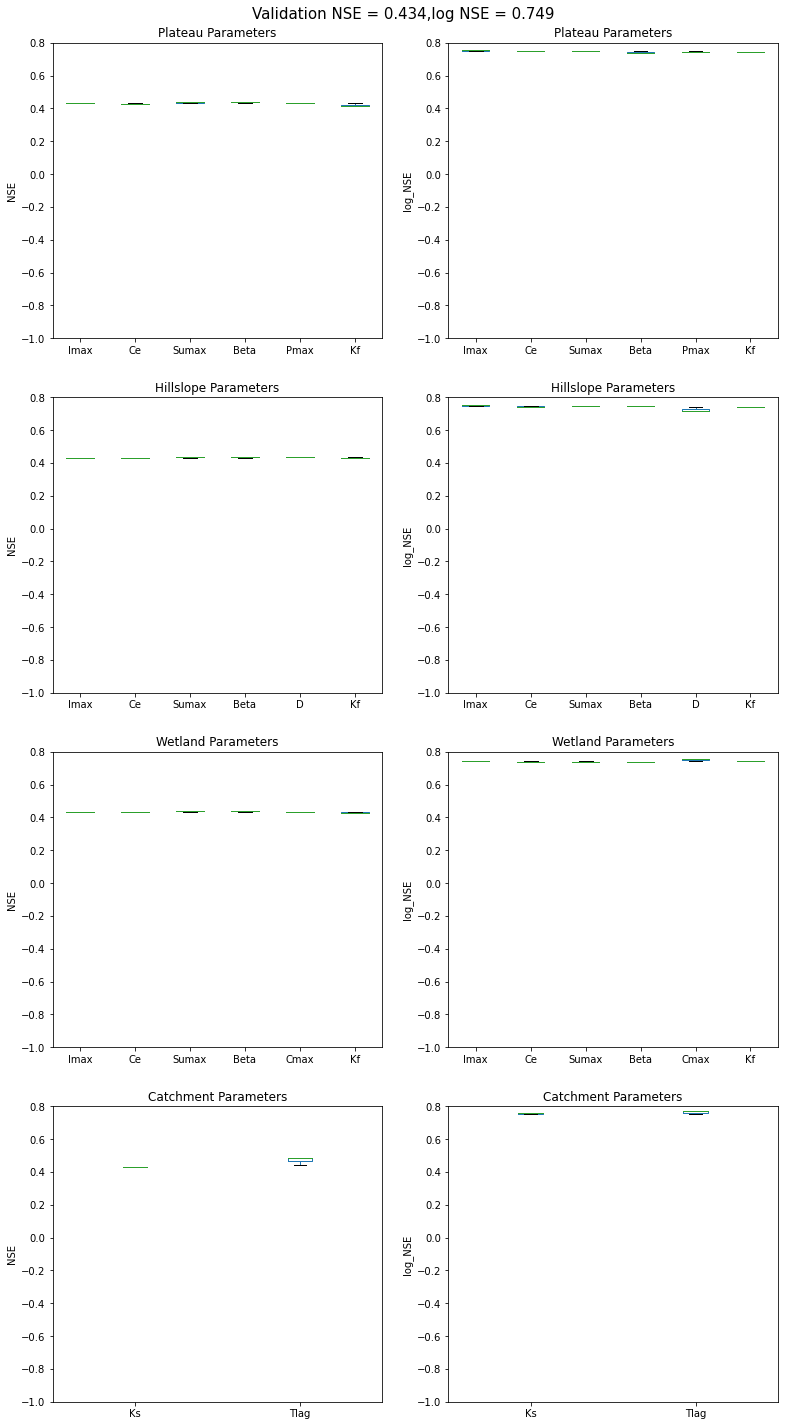

In [13]:
OptPar= np.genfromtxt('Opt_Par_set.txt', delimiter =',', dtype=float, autostrip=True)
forcing=np.genfromtxt('WarkEttelbruck.txt',  dtype=float, autostrip=True)
forcing= forcing[:,1:4]
forcing_cal=forcing[:440,:]
forcing_val=forcing[440:,:]
Q0= forcing[0]
tsp=60# Spin up time
#landscape percentages
land_distr=np.array([0.44316-0.00630514346380575, 0.44550-0.006338390188025569, 0.12577-0.0017894560388902797])
#Initial States
in_states=np.zeros((3,3))
#in_states[:,2]= [40,5,10] 
slow_res=5
par = np.zeros((3, 20))
NSE = np.zeros((3, 20))
log_NSE = np.zeros((3, 20))
ParPlateau =OptPar[0,:]
ParHillslope = OptPar[1,:]
ParWetland = OptPar[2,:]
ParCatchment = OptPar[3,:2]
NSE_cal,log_NSE_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
NSE_val,log_NSE_val,Qm,S_final,Ss_final,WB=FLEXtopo(OptPar[0,:],OptPar[1,:],OptPar[2,:],OptPar[3,:2],forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
pcnt_range = np.array([0.8,1,1.2])
for i in range(4):
    if i==0:
        for j in range(6):
            for n in range(3):
                    
                ParPlateau[j]= ParPlateau[j] * pcnt_range[n]
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParPlateau[j]=OptPar[0,j]
    if i==1:
        for j in range(6,12):
            for n in range(3):
                
                ParHillslope[j-6]= ParHillslope[j-6] * pcnt_range[n]
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParHillslope[j-6]=OptPar[1,j-6]
    if i==2:
        for j in range(12,18):
            for n in range(3):
                
                ParWetland[j-12]= ParWetland[j-12] * pcnt_range[n]
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParWetland[j-12]=OptPar[2,j-12]
    if i==3:
        for j in range(18,20):
            for n in range(3):
                
                ParCatchment[j-18]= ParCatchment[j-18] * pcnt_range[n]
                NS_cal,log_NS_cal,Qm_cal,S_final_cal,Ss_final,WB_cal=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_cal,landscapes=land_distr,in_states=in_states,slow_res=slow_res,spin_up_time='TRUE')
                NS,log_NS,Qm,S_final,Ss_final,WB=FLEXtopo(ParPlateau,ParHillslope,ParWetland,ParCatchment,forcing=forcing_val,landscapes=land_distr,in_states=S_final_cal,slow_res=Ss_final,spin_up_time='FALSE')
                NSE[n,j]= float(NS)
                log_NSE[n,j]=float(log_NS)
                ParCatchment[j-18]=OptPar[3,j-18]
#
Plataeu , log_Plataeu = pd.DataFrame(data=NSE[:,0:6],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Kf']) , pd.DataFrame(data=log_NSE[:,0:6],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Kf'])
Hillslpoe , log_Hillslpoe = pd.DataFrame(data=NSE[:,6:12],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'D', 'Kf']) , pd.DataFrame(data=log_NSE[:,6:12],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'D', 'Kf'])
Wetland , log_Wetland = pd.DataFrame(data=NSE[:,12:18],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Cmax', 'Kf']) , pd.DataFrame(data=log_NSE[:,12:18],columns=['Imax', 'Ce', 'Sumax', 'Beta', 'Cmax', 'Kf'])
Catchment , log_Catchment = pd.DataFrame(data=NSE[:,18:20],columns=['Ks', 'Tlag']) , pd.DataFrame(data=log_NSE[:,18:20],columns=['Ks', 'Tlag'])
#
fig=plt.figure(figsize=(13,25))
plt.suptitle('Validation NSE = '+str(np.round(NSE_val,3))+',log NSE = '+str(np.round(log_NSE_val,3)),y=0.9,fontsize=15)
plt.subplot(421)
plt.ylabel('NSE')
plt.ylim(-1,0.8)
plt.title('Plateau Parameters')
Plataeu.plot.box(ax = plt.gca(), sym = '')
plt.subplot(422)
plt.ylabel('log_NSE')
plt.ylim(-1,0.8)
plt.title('Plateau Parameters')
log_Plataeu.plot.box(ax = plt.gca(), sym = '')
plt.subplot(423)
plt.ylabel('NSE')
plt.ylim(-1,0.8)
plt.title('Hillslope Parameters')
Hillslpoe.plot.box(ax = plt.gca(), sym = '')
plt.subplot(424)
plt.ylabel('log_NSE')
plt.ylim(-1,0.8)
plt.title('Hillslope Parameters')
log_Hillslpoe.plot.box(ax = plt.gca(), sym = '')
plt.subplot(425)
plt.ylabel('NSE')
plt.ylim(-1,0.8)
plt.title('Wetland Parameters')
Wetland.plot.box(ax = plt.gca(), sym = '')
plt.subplot(426)
plt.ylabel('log_NSE')
plt.ylim(-1,0.8)
plt.title('Wetland Parameters')
log_Wetland.plot.box(ax = plt.gca(), sym = '')
plt.subplot(427)
plt.ylabel('NSE')
plt.ylim(-1,0.8)
plt.title('Catchment Parameters')
Catchment.plot.box(ax = plt.gca(), sym = '')
plt.subplot(428)
plt.ylabel('log_NSE')
plt.ylim(-1,0.8)
plt.title('Catchment Parameters')
log_Catchment.plot.box(ax = plt.gca(), sym = '')
plt.savefig('Sensitivity20%_figure_NSE_log_NSE.png')